In [40]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../../")
import collections
import re
import numpy as np
from utils.readvcf_snp import ReadVCF

from utils import fst as Fst_calc

pheno_file = "/cbscratch/franco/datasets/gtex_v8/phenotypes/gtex_v8_basic_phenotypes.txt"
#admix_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex-admixed0.9.txt"
gteur_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
gtall_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"

def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
        nsample = sample
        samplenames = samplenames
        return samplenames, nsample
    
allsamples, nall = read_samples(gtall_file)

sample_pheno_dict = dict()
with open(pheno_file) as instream:
    for line in instream:
        if line.strip() == "":
            continue
        if re.search("#", line):
            continue
        if re.search("dbGaP", line):
            header = line.strip().split()
            continue
        arr = line.strip().split("\t")
        sampleid = arr[1]
        race = arr[5]
        sample_pheno_dict[sampleid] = race
        
# "1" "Asian"
# "2" "Black or African American"
# "3" "White"
# "4" "American Indian or Alaska Native"
# "98" "Not Reported"
# "99" "Unknown"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# def calc_simple_fst_power(pops_gt, pops): 
    
#     nsnps = pops_gt[pops[0]].shape[0]
#     for j in range(1, len(pops)):
#         if nsnps != pops_gt[pops[j]].shape[0]:
#             print("SNP numbers differ between populations")
#             raise
    
#     power_list = list()
#     fst_list = list()
#     # all_gt = np.hstack((eur_gt1kg, afr_gt1kg))
#     all_gt = np.hstack(tuple([pops_gt[x] for x in pops]))
#     all_n  = all_gt.shape[1] # size of total population
#     for snpi in range(all_gt.shape[0]):
#         #print(snp_info[snpi])
#         # maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
#         # maf_eur = sum(eur_gt[snpi,:] / 2 / len(eur_gt[snpi,:]))
#         # maf_afr = sum(afr_gt[snpi,:] / 2 / len(afr_gt[snpi,:]))
#         if np.all(all_gt[snpi,:] == all_gt[snpi,0]):
#             print("Warning!")
#         maf_all = sum(all_gt[snpi,:] / 2 / len(all_gt[snpi,:]))
#         maf_pops = [sum(pops_gt[x][snpi,:] / 2 / len(pops_gt[x][snpi,:])) for x in pops]

#         c_pops = [pops_gt[x].shape[1]/all_n for x in pops]
#         #c_eur = eur_n / all_n
#         #c_afr = afr_n / all_n
        
#         p_all = maf_all*(1-maf_all)
#         sum_p = np.sum(np.array([c_pops[i]*maf_pops[i]*(1-maf_pops[i]) for i in range(len(pops))]))
#         power = all_n * sum_p # (c_eur*maf_eur*(1-maf_eur) + c_afr*maf_afr*(1-maf_afr) )
        
#         Fst = (p_all  - sum_p ) / p_all
#         power_list.append(power)
#         fst_list.append(Fst)
#     return fst_list, power_list


# def get_gt_count(dosage, allele='ref'):
#     n_het = dosage.count(1)
#     if allele == "ref":
#         n_hom = dosage.count(0)
#     if allele == "alt":
#         n_hom = dosage.count(2)
#     return n_hom, n_het

# def weir_cockerman_fst(pops_gt, pops=["eur", "afr"], alleles=["ref", "alt"]):
    
#     fst_list = list()
#     nsnps = pops_gt[pops[0]].shape[0]
#     if nsnps != pops_gt[pops[1]].shape[0]:
#         print("SNP numbers differ between populations")
#         raise
        
#     for snpi in range(nsnps):
#         n_pops = len(pops)
#         n_alleles = len(alleles)
#         n = np.zeros(n_pops)
#         p = np.zeros((n_pops, n_alleles))
#         pbar = np.zeros(n_alleles)
#         hbar = np.zeros(n_alleles)
#         ssqr = np.zeros(n_alleles)

#         nbar = 0.0
#         sum_nsqr = 0.0
#         n_sum = 0.0
#         for pop in range(n_pops):
#             for al in range(n_alleles):
#                 n_hom, n_het = get_gt_count(list(pops_gt[pops[pop]][snpi,:]), allele=alleles[al])
#                 n[pop] += n_hom + 0.5*n_het
#                 p[pop,al] = n_het + 2*n_hom

#                 nbar += n[pop]
#                 pbar[al] += p[pop][al]
#                 hbar[al] += n_het
#             for al in range(n_pops):
#                 p[pop,al] /= 2.0*n[pop]

#             sum_nsqr += (n[pop] * n[pop])

#         n_sum = sum(n)
#         nbar  = n_sum / n_pops

#         for al in range(n_alleles):
#             pbar[al] /= (n_sum * 2.0)
#             hbar[al] /= n_sum

#         for al in range(n_alleles):
#             for pop in range(n_pops):
#                 ssqr[al] += n[pop]*(p[pop,al] - pbar[al])*(p[pop,al] - pbar[al])
#             ssqr[al] /= (n_pops-1)*nbar
#         nc = (n_sum - (sum_nsqr / n_sum)) / (n_pops - 1)

#         snp_Fst = np.zeros(n_alleles)
#         a = np.zeros(n_alleles)
#         b = np.zeros(n_alleles)
#         c = np.zeros(n_alleles)
#         r = n_pops
#         sum_a = 0.0
#         sum_all = 0.0
#         for al in range(n_alleles):
#             a[al] = (ssqr[al] - ( pbar[al]*(1.0-pbar[al]) - (((r-1.0)*ssqr[al])/r) - (hbar[al]/4.0) )/(nbar-1.0))*nbar/nc;
#             b[al] = (pbar[al]*(1.0-pbar[al]) - (ssqr[al]*(r-1.0)/r) - hbar[al]*( ((2.0*nbar)-1.0) / (4.0*nbar) ))*nbar / (nbar-1.0) ;
#             c[al] = hbar[al] / 2.0;
#             snp_Fst[al] = a[al]/(a[al]+b[al]+c[al]);

#             if not np.all([np.isnan(a[al]),np.isnan(b[al]),np.isnan(c[al])]):
#                 sum_a += a[al]
#                 sum_all += a[al] + b[al] + c[al]
#         fst = sum_a/sum_all
#         fst_list.append(fst)
#     return fst_list

In [3]:
import json
from utils import utils

tissue_file = "../../plots/tissue_table.txt"
json_file   = "../../gtex_v8_metadata.json"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        tissue_nsamples[tshort] = gtex_meta[tfull]["rnaSeqSampleCount"]
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
altsb_tissues = ['haa', 'pan', 'spl', 'wb']

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            #chrom = rsid.split("_")[0][3:]
            chrom = int(arr[1])
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res    
    
basename = "protein_coding_lncRNA_{:s}_knn30_cut5e-8"
gammas = ["gamma01", "gamma0006"]

In [4]:
basepath = "/cbscratch/franco/trans-eqtl"
trans_dict = dict()
for tissue in tshorts:
    if tissue in altsb_tissues:
        config = basename.format(gammas[1])
    else:
        config = basename.format(gammas[0])
    tejaas_file = os.path.join(basepath, config, tissue, "trans_eqtls_ldpruned.txt")
    
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue, end="")
    transeqtls = tejaas(tejaas_file)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
        print(" has {:d} trans-eqtls".format(len(transeqtls)))
    else:
        trans_dict[tissue] = []
        print(" has 0 trans-eqtls")

Loading  as has 586 trans-eqtls
Loading  av has 463 trans-eqtls
Loading  ag has 184 trans-eqtls
Loading  aa has 1298 trans-eqtls
Loading  ac has 1539 trans-eqtls
Loading  at has 391 trans-eqtls
Loading  bam has 1182 trans-eqtls
Loading  ban has 954 trans-eqtls
Loading  bca has 19 trans-eqtls
Loading  bceh has 128 trans-eqtls
Loading  bce has 40 trans-eqtls
Loading  bco has 64 trans-eqtls
Loading  bfr has 32 trans-eqtls
Loading  bhi has 51 trans-eqtls
Loading  bhy has 83 trans-eqtls
Loading  bnu has 379 trans-eqtls
Loading  bpu has 10 trans-eqtls
Loading  bsp has 61 trans-eqtls
Loading  bsu has 28 trans-eqtls
Loading  br has 505 trans-eqtls
Loading  ebv has 297 trans-eqtls
Loading  fib has 209 trans-eqtls
Loading  cols has 75 trans-eqtls
Loading  colt has 1174 trans-eqtls
Loading  esog has 17 trans-eqtls
Loading  esom has 9 trans-eqtls
Loading  esomu has 20 trans-eqtls
Loading  haa has 64 trans-eqtls
Loading  hlv has 247 trans-eqtls
Loading  kc has 14 trans-eqtls
Loading  liv has 37 tra

In [5]:
teqtl_varids = list()
for tissue in tshorts:
    teqtl_varids += [snp.rsid for snp in trans_dict[tissue]]
teqtl_varids = list(set(teqtl_varids))

chrm_teqtls = dict()
suma = 0
for chrm in range(1,23):
    chrm_teqtls[chrm] = [x for x in teqtl_varids if x.startswith("chr{:d}_".format(chrm))]
    print(f"chr{chrm} has {len(chrm_teqtls[chrm])} trans-eqtls")
    suma += len(chrm_teqtls[chrm])
print(suma)
print(len(teqtl_varids))

chr1 has 1423 trans-eqtls
chr2 has 1629 trans-eqtls
chr3 has 1410 trans-eqtls
chr4 has 1180 trans-eqtls
chr5 has 1003 trans-eqtls
chr6 has 1176 trans-eqtls
chr7 has 1075 trans-eqtls
chr8 has 855 trans-eqtls
chr9 has 906 trans-eqtls
chr10 has 983 trans-eqtls
chr11 has 853 trans-eqtls
chr12 has 827 trans-eqtls
chr13 has 495 trans-eqtls
chr14 has 637 trans-eqtls
chr15 has 722 trans-eqtls
chr16 has 915 trans-eqtls
chr17 has 720 trans-eqtls
chr18 has 529 trans-eqtls
chr19 has 414 trans-eqtls
chr20 has 514 trans-eqtls
chr21 has 301 trans-eqtls
chr22 has 284 trans-eqtls
18851
18851


In [6]:
SNPGT_FIELDS = ['varid', 'chrom', 'pos', 'maf', 'dosage']
class SNPGT(collections.namedtuple('_SNPGT', SNPGT_FIELDS)):
    __slots__ = ()

full_teqtls_gt = collections.defaultdict(dict)
first_donors = list()
for chrm in range(1,23):
    print(f"Reading CHR{chrm}")
    f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
    # f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/ldpruned/GTEX_v8.SHAPEIT2_chr1.ldpruned.vcf.gz"
    # samplefile = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
    samplefile = None
    vcf = ReadVCF(f_vcf, snplist=chrm_teqtls[chrm])
    gtfull = vcf.dosage
    gt_donors = vcf.donor_ids
    if chrm == 1:
        first_donors = gt_donors
    else:
        if not first_donors == gt_donors:
            print("donor error!")
            raise
    snpinfos = vcf.snpinfo
    for i,snp in enumerate(snpinfos):
        full_teqtls_gt[chrm][snp.varid] = SNPGT(varid=snp.varid, chrom=snp.chrom, pos=snp.bp_pos, maf=snp.maf, dosage=gtfull[i,:])

Reading CHR1
all 1423 found!
Reading CHR2
all 1629 found!
Reading CHR3
all 1410 found!
Reading CHR4
all 1180 found!
Reading CHR5
all 1003 found!
Reading CHR6
all 1176 found!
Reading CHR7
all 1075 found!
Reading CHR8
all 855 found!
Reading CHR9
all 906 found!
Reading CHR10
all 983 found!
Reading CHR11
all 853 found!
Reading CHR12
all 827 found!
Reading CHR13
all 495 found!
Reading CHR14
all 637 found!
Reading CHR15
all 722 found!
Reading CHR16
all 915 found!
Reading CHR17
all 720 found!
Reading CHR18
all 529 found!
Reading CHR19
all 414 found!
Reading CHR20
all 514 found!
Reading CHR21
all 301 found!
Reading CHR22
all 284 found!


In [7]:
# read the samples for each tissue
expr_dir = "/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms"
expr_file = os.path.join(expr_dir, "{:s}_tpms_qcfilter.txt")

tissue_samples = dict()
for tissue in tshorts:
    with open(expr_file.format(tissue)) as instream:
        samplenames = instream.readline().strip().split("\t")[1:]
        tissue_samples[tissue] = samplenames

In [65]:
def match_samples(gt_donors, expr_donors):
    common  = [x for x in gt_donors if x in expr_donors]
    vcfmask = [gt_donors.index(x) for x in common]
    return vcfmask, common

def find_ancestry(samples, sample_pheno_dict):
    ix_eur = list()
    ix_afr = list()
    for i,sid in enumerate(samples):
        if sample_pheno_dict[sid] == '2':
            ix_afr.append(i)
        if sample_pheno_dict[sid] == '3':
            ix_eur.append(i)
    return ix_eur, ix_afr

# tissue_ancestry = collections.defaultdict(dict)
teqtl_tissue_fst = collections.defaultdict(dict)
for tissue in tshorts:
    # tissue = "as"
    vcfmask, sampids = match_samples(gt_donors, tissue_samples[tissue])
    pops = ["eur", "afr"]
    alleles = ["ref", "alt"]
    ix_eur, ix_afr = find_ancestry(sampids, sample_pheno_dict)
    # tissue_ancestry[tissue]["eur"] = len(ix_eur)
    # tissue_ancestry[tissue]["afr"] = len(ix_afr)
    print(f"{tissue}: {len(ix_eur)} EUR, {len(ix_afr)} AFR, Total: {len(vcfmask)}")
    for snp in trans_dict[tissue]:
        # print(snp.rsid)
        chrm = int(snp.rsid.split("_")[0][3:])
        snp_data = full_teqtls_gt[chrm][snp.rsid]
        pops_gt = dict()
        pops_gt["eur"] = np.array([snp_data.dosage[i] for i in ix_eur]).reshape(1,-1)
        pops_gt["afr"] = np.array([snp_data.dosage[i] for i in ix_afr]).reshape(1,-1)
        fsts_gtex, power_gtex = Fst_calc.calc_simple_fst_power(pops_gt, pops)
        weir_fsts_gtex = Fst_calc.weir_cockerman_fst(pops_gt, pops, alleles)
        teqtl_tissue_fst[tissue][snp.rsid] = [weir_fsts_gtex[0], fsts_gtex[0], power_gtex[0]]
        # print(teqtl_tissue_fst[tissue][snp.rsid])

as: 492 EUR, 71 AFR, Total: 581
av: 402 EUR, 51 AFR, Total: 469
ag: 200 EUR, 25 AFR, Total: 233
aa: 338 EUR, 38 AFR, Total: 387
ac: 180 EUR, 25 AFR, Total: 213
at: 489 EUR, 76 AFR, Total: 584
bam: 119 EUR, 10 AFR, Total: 129
ban: 136 EUR, 11 AFR, Total: 147
Warning!


../../utils/fst.py:112: RuntimeWarning: invalid value encountered in double_scalars
  snp_Fst[al] = a[al]/(a[al]+b[al]+c[al]);
../../utils/fst.py:117: RuntimeWarning: invalid value encountered in double_scalars
  fst = sum_a/sum_all


bca: 173 EUR, 19 AFR, Total: 194
bceh: 158 EUR, 16 AFR, Total: 175
Warning!
bce: 189 EUR, 19 AFR, Total: 209
bco: 184 EUR, 20 AFR, Total: 205
bfr: 158 EUR, 17 AFR, Total: 175
bhi: 151 EUR, 14 AFR, Total: 165
bhy: 157 EUR, 12 AFR, Total: 170
bnu: 182 EUR, 18 AFR, Total: 202
bpu: 154 EUR, 15 AFR, Total: 170
bsp: 115 EUR, 10 AFR, Total: 126
bsu: 101 EUR, 12 AFR, Total: 114
br: 337 EUR, 47 AFR, Total: 396
ebv: 116 EUR, 29 AFR, Total: 147
fib: 416 EUR, 58 AFR, Total: 483
cols: 273 EUR, 34 AFR, Total: 318
colt: 305 EUR, 50 AFR, Total: 368
esog: 281 EUR, 36 AFR, Total: 330
esom: 424 EUR, 60 AFR, Total: 497
esomu: 396 EUR, 55 AFR, Total: 465
haa: 322 EUR, 42 AFR, Total: 372
hlv: 334 EUR, 42 AFR, Total: 386
kc: 65 EUR, 8 AFR, Total: 73
liv: 183 EUR, 19 AFR, Total: 208
lu: 444 EUR, 58 AFR, Total: 515
msg: 118 EUR, 23 AFR, Total: 144
ms: 602 EUR, 86 AFR, Total: 706
nt: 449 EUR, 67 AFR, Total: 532
ov: 140 EUR, 21 AFR, Total: 167
Warning!
pan: 252 EUR, 39 AFR, Total: 305
pit: 220 EUR, 16 AFR, Total

# Include other ancestry group

In [64]:
def find_ancestry_3pop(samples, sample_pheno_dict):
    ix_eur = list()
    ix_afr = list()
    ix_oth = list()
    for i,sid in enumerate(samples):
        if sample_pheno_dict[sid] == '2':
            ix_afr.append(i)
        elif sample_pheno_dict[sid] == '3':
            ix_eur.append(i)
        else:
            ix_oth.append(i)
    return ix_eur, ix_afr, ix_oth

tissue_ancestry = collections.defaultdict(dict)
teqtl_tissue_fst_3pop = collections.defaultdict(dict)
for tissue in tshorts:
    # tissue = "as"
    vcfmask, sampids = match_samples(gt_donors, tissue_samples[tissue])
    pops = ["eur", "afr", "oth"]
    alleles = ["ref", "alt"]
    ix_eur, ix_afr, ix_oth = find_ancestry_3pop(sampids, sample_pheno_dict)
    tissue_ancestry[tissue]["eur"] = len(ix_eur)
    tissue_ancestry[tissue]["afr"] = len(ix_afr)
    tissue_ancestry[tissue]["oth"] = len(ix_oth)
    print(f"{tissue}: {len(ix_eur)} EUR, {len(ix_afr)} AFR, {len(ix_oth)} OTHER, Total: {len(vcfmask)}")
    for snp in trans_dict[tissue]:
        # print(snp.rsid)
        chrm = int(snp.rsid.split("_")[0][3:])
        snp_data = full_teqtls_gt[chrm][snp.rsid]
        pops_gt = dict()
        pops_gt["eur"] = np.array([snp_data.dosage[i] for i in ix_eur]).reshape(1,-1)
        pops_gt["afr"] = np.array([snp_data.dosage[i] for i in ix_afr]).reshape(1,-1)
        pops_gt["oth"] = np.array([snp_data.dosage[i] for i in ix_oth]).reshape(1,-1)
        fsts_gtex, power_gtex = Fst_calc.calc_simple_fst_power(pops_gt, pops)
        weir_fsts_gtex = Fst_calc.weir_cockerman_fst(pops_gt, pops, alleles)
        teqtl_tissue_fst_3pop[tissue][snp.rsid] = [weir_fsts_gtex[0], fsts_gtex[0], power_gtex[0]]
        # print(teqtl_tissue_fst[tissue][snp.rsid])

as: 492 EUR, 71 AFR, 18 OTHER, Total: 581
av: 402 EUR, 51 AFR, 16 OTHER, Total: 469
ag: 200 EUR, 25 AFR, 8 OTHER, Total: 233
aa: 338 EUR, 38 AFR, 11 OTHER, Total: 387
ac: 180 EUR, 25 AFR, 8 OTHER, Total: 213
at: 489 EUR, 76 AFR, 19 OTHER, Total: 584
bam: 119 EUR, 10 AFR, 0 OTHER, Total: 129


../../utils/fst.py:84: RuntimeWarning: invalid value encountered in double_scalars
  p[pop,al] /= 2.0*n[pop]


ban: 136 EUR, 11 AFR, 0 OTHER, Total: 147
Warning!
bca: 173 EUR, 19 AFR, 2 OTHER, Total: 194
bceh: 158 EUR, 16 AFR, 1 OTHER, Total: 175
Warning!
bce: 189 EUR, 19 AFR, 1 OTHER, Total: 209
bco: 184 EUR, 20 AFR, 1 OTHER, Total: 205
bfr: 158 EUR, 17 AFR, 0 OTHER, Total: 175
bhi: 151 EUR, 14 AFR, 0 OTHER, Total: 165
bhy: 157 EUR, 12 AFR, 1 OTHER, Total: 170
bnu: 182 EUR, 18 AFR, 2 OTHER, Total: 202


../../utils/fst.py:112: RuntimeWarning: invalid value encountered in double_scalars
  snp_Fst[al] = a[al]/(a[al]+b[al]+c[al]);
../../utils/fst.py:117: RuntimeWarning: invalid value encountered in double_scalars
  fst = sum_a/sum_all


bpu: 154 EUR, 15 AFR, 1 OTHER, Total: 170
bsp: 115 EUR, 10 AFR, 1 OTHER, Total: 126
bsu: 101 EUR, 12 AFR, 1 OTHER, Total: 114
br: 337 EUR, 47 AFR, 12 OTHER, Total: 396
ebv: 116 EUR, 29 AFR, 2 OTHER, Total: 147
fib: 416 EUR, 58 AFR, 9 OTHER, Total: 483
cols: 273 EUR, 34 AFR, 11 OTHER, Total: 318
colt: 305 EUR, 50 AFR, 13 OTHER, Total: 368
esog: 281 EUR, 36 AFR, 13 OTHER, Total: 330
esom: 424 EUR, 60 AFR, 13 OTHER, Total: 497
esomu: 396 EUR, 55 AFR, 14 OTHER, Total: 465
haa: 322 EUR, 42 AFR, 8 OTHER, Total: 372
hlv: 334 EUR, 42 AFR, 10 OTHER, Total: 386
kc: 65 EUR, 8 AFR, 0 OTHER, Total: 73
liv: 183 EUR, 19 AFR, 6 OTHER, Total: 208
lu: 444 EUR, 58 AFR, 13 OTHER, Total: 515
msg: 118 EUR, 23 AFR, 3 OTHER, Total: 144
ms: 602 EUR, 86 AFR, 18 OTHER, Total: 706
nt: 449 EUR, 67 AFR, 16 OTHER, Total: 532
ov: 140 EUR, 21 AFR, 6 OTHER, Total: 167
Warning!
pan: 252 EUR, 39 AFR, 14 OTHER, Total: 305
pit: 220 EUR, 16 AFR, 1 OTHER, Total: 237
pro: 186 EUR, 27 AFR, 8 OTHER, Total: 221
snse: 440 EUR, 62

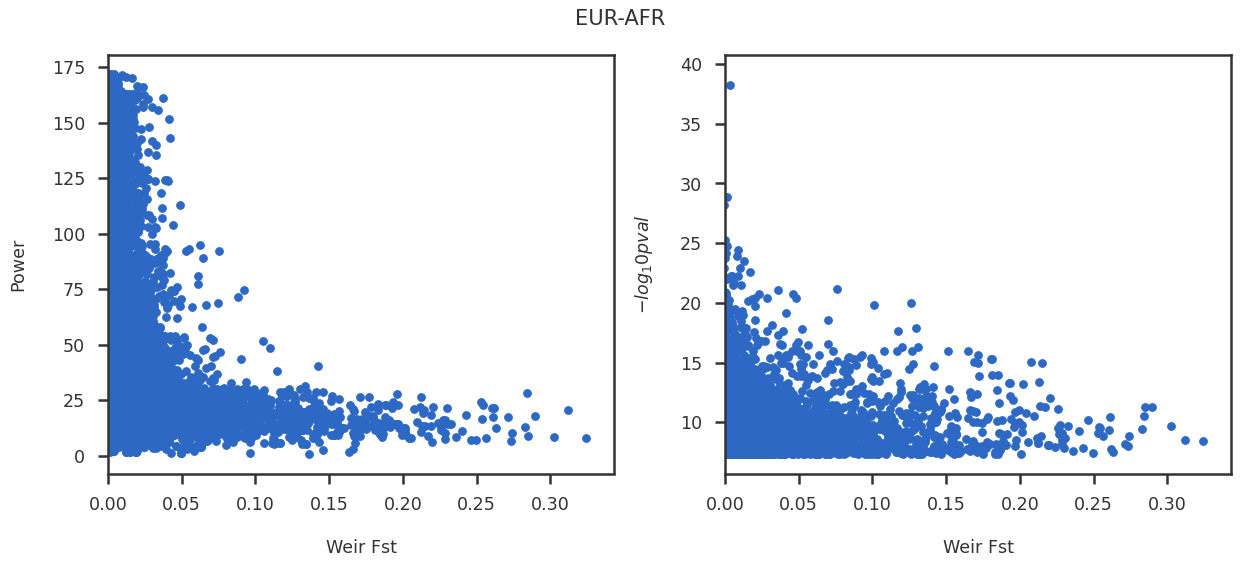

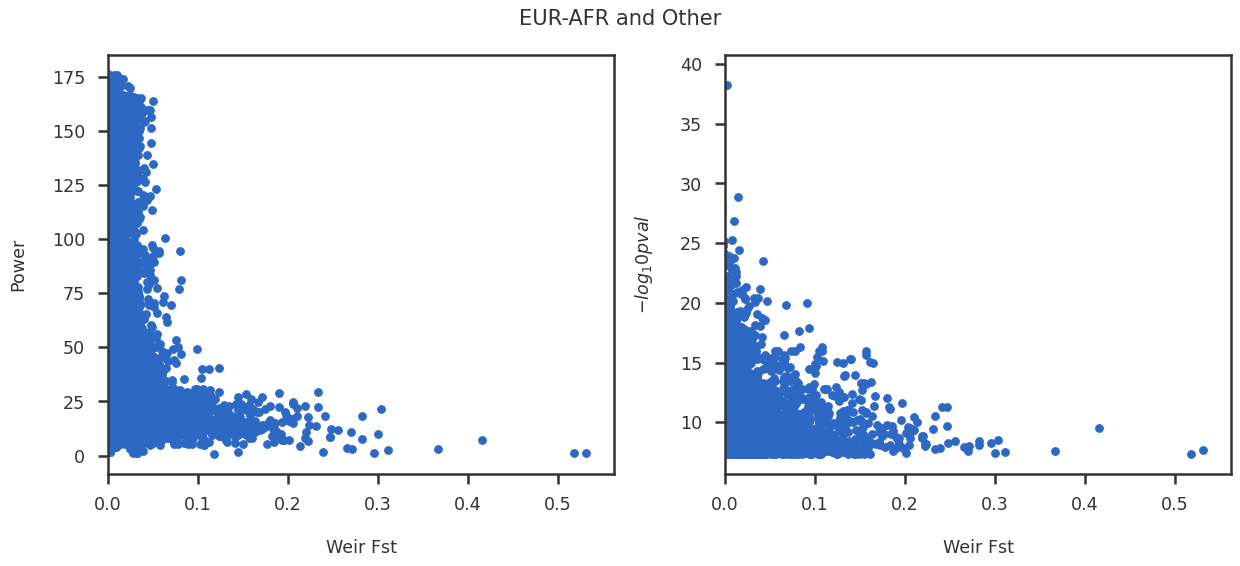

In [50]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

fig = plt.figure(figsize=(14,6))
fig.suptitle("EUR-AFR", y=1.05)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fst_arr = list()
power_arr = list()
weir_arr = list()
pval_arr = list()
for tissue in tshorts:
    for snp in trans_dict[tissue]:
        # print(snp)
        weir, fst, power = teqtl_tissue_fst[tissue][snp.rsid]
        weir_arr.append(weir)
        fst_arr.append(fst)
        power_arr.append(power)
        pval_arr.append(snp.logp)
ax1.scatter(weir_arr, power_arr)
ax1.set_xlim(0,)
ax1.set_xlabel("Weir Fst")
ax1.set_ylabel("Power")

ax2.scatter(weir_arr, pval_arr)
ax2.set_xlim(0,)
ax2.set_xlabel("Weir Fst")
ax2.set_ylabel("$-log_10 pval$")

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14,6))
fig.suptitle("EUR-AFR and Other", y=1.05)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fst_arr = list()
power_arr = list()
weir_arr = list()
pval_arr = list()
for tissue in tshorts:
    for snp in trans_dict[tissue]:
        # print(snp)
        weir, fst, power = teqtl_tissue_fst_3pop[tissue][snp.rsid]
        weir_arr.append(weir)
        fst_arr.append(fst)
        power_arr.append(power)
        pval_arr.append(snp.logp)
ax1.scatter(weir_arr, power_arr)
ax1.set_xlim(0,)
ax1.set_xlabel("Weir Fst")
ax1.set_ylabel("Power")

ax2.scatter(weir_arr, pval_arr)
ax2.set_xlim(0,)
ax2.set_xlabel("Weir Fst")
ax2.set_ylabel("$-log_{10} pval$")


plt.tight_layout()
plt.show()

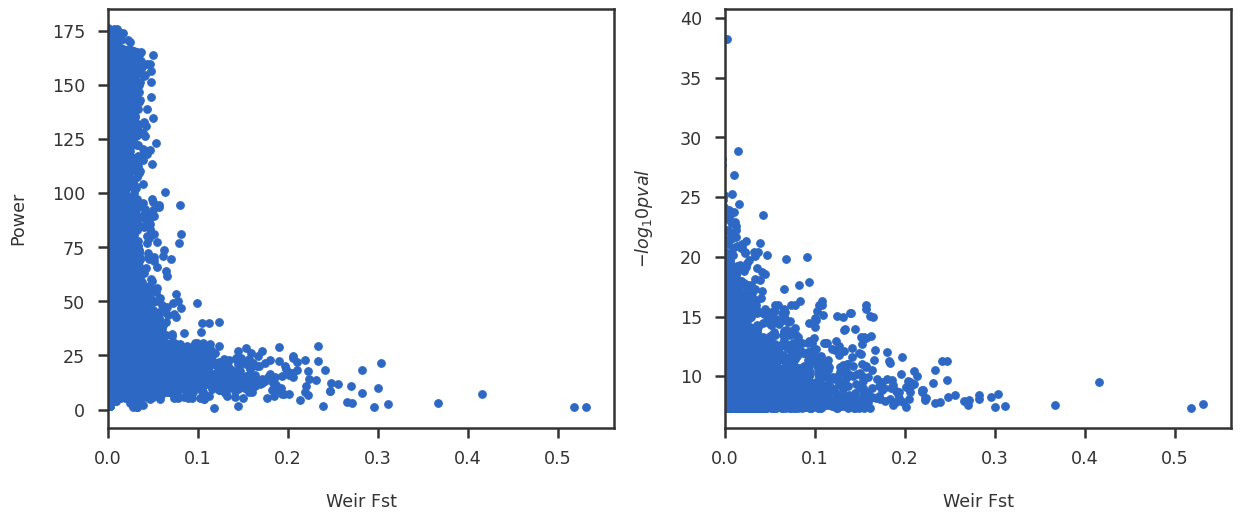

In [43]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

fst_arr = list()
power_arr = list()
weir_arr = list()
pval_arr = list()
for tissue in tshorts:
    for snp in trans_dict[tissue]:
        # print(snp)
        weir, fst, power = teqtl_tissue_fst[tissue][snp.rsid]
        weir_arr.append(weir)
        fst_arr.append(fst)
        power_arr.append(power)
        pval_arr.append(snp.logp)
ax1.scatter(weir_arr, power_arr)
ax1.set_xlim(0,)
ax1.set_xlabel("Weir Fst")
ax1.set_ylabel("Power")

ax2.scatter(weir_arr, pval_arr)
ax2.set_xlim(0,)
ax2.set_xlabel("Weir Fst")
ax2.set_ylabel("$-log_10 pval$")

plt.tight_layout()
plt.show()

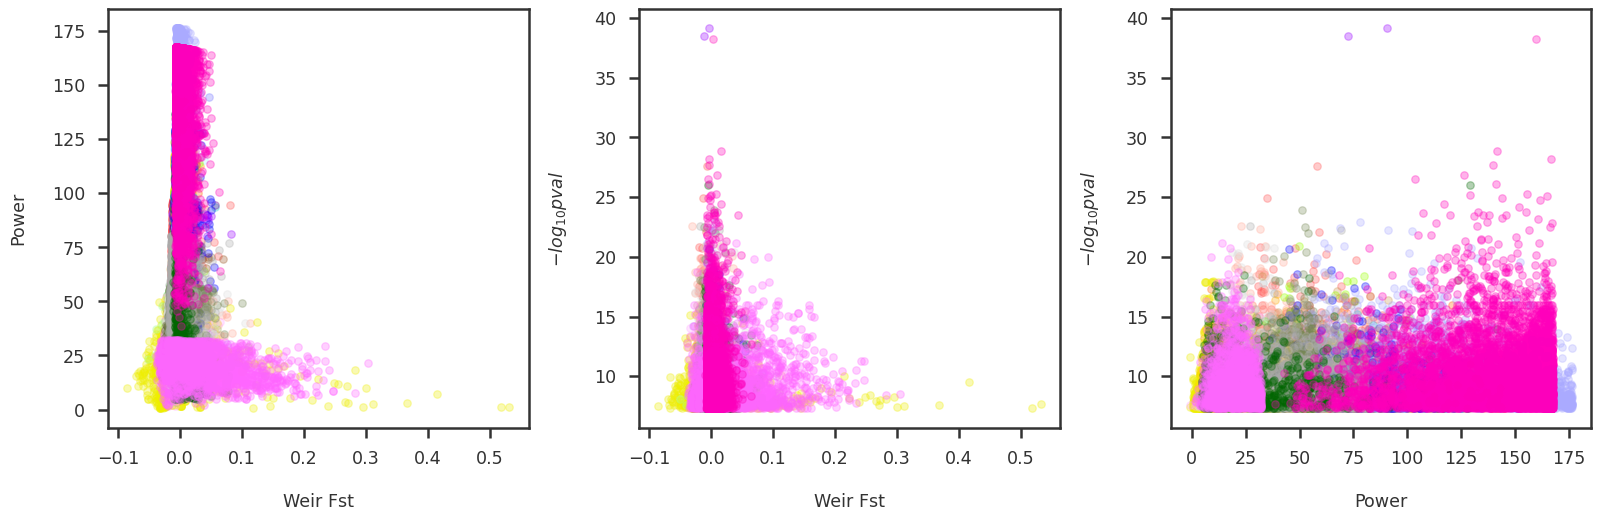

In [101]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for tissue in tshorts:
#     if tissue != "ut":
#         continue
    fst_arr = list()
    power_arr = list()
    weir_arr = list()
    pval_arr = list()
    for snp in trans_dict[tissue]:
        # print(snp)
        weir, fst, power = teqtl_tissue_fst_3pop[tissue][snp.rsid]
        weir_arr.append(weir)
        fst_arr.append(fst)
        power_arr.append(power)
        pval_arr.append(snp.logp)
    ax1.scatter(weir_arr, power_arr, color=tissue_colors[tissue], alpha=0.3)
    ax1.set_xlabel("Weir Fst")
    ax1.set_ylabel("Power")

    ax2.scatter(weir_arr, pval_arr, color=tissue_colors[tissue], alpha=0.3)
    ax2.set_xlabel("Weir Fst")
    ax2.set_ylabel("$-log_{10} pval$")
    
    ax3.scatter(power_arr, pval_arr, color=tissue_colors[tissue], alpha=0.3)
    ax3.set_xlabel("Power")
    ax3.set_ylabel("$-log_{10} pval$")
    
# ax1.set_xlim(0,)
# ax2.set_xlim(0,)
# ax3.set_xlim(0,)

plt.tight_layout()
plt.show()

# Calculate on 3 GTEx tissues on 3 chr each

In [87]:
from utils import readgt

gtfull = np.array([])
snpinfos = list()
# Use real genotype
for chrm in range(10,12):
    f_vcf = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz".format(chrm)
    samplefile = None
    gtfull_chrm, snpinfos_chrm, gt_donors = readgt.read_vcf(f_vcf, 0, 100000, samplefile=samplefile)
    if gtfull.shape[0] == 0:
        gtfull = gtfull_chrm
    else:
        gtfull = np.vstack((gtfull, gtfull_chrm))
    snpinfos += snpinfos_chrm
snp_info, dosage = readgt.filter_snps(snpinfos, gtfull)

Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of unknown allele symbol
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 0 SNPs because of low MAF (current)


In [88]:
# tissue_ancestry = collections.defaultdict(dict)
gw_tissue_fst = collections.defaultdict(dict)
select_tissues = ["sse", "ms", "wb", 'ut']
for tissue in select_tissues:
    # tissue = "as"
    vcfmask, sampids = match_samples(gt_donors, tissue_samples[tissue])
    pops = ["eur", "afr", "oth"]
    alleles = ["ref", "alt"]
    ix_eur, ix_afr, ix_oth = find_ancestry_3pop(sampids, sample_pheno_dict)
    # tissue_ancestry[tissue]["eur"] = len(ix_eur)
    # tissue_ancestry[tissue]["afr"] = len(ix_afr)
    print(f"{tissue}: {len(ix_eur)} EUR, {len(ix_afr)} AFR, {len(ix_oth)} OTHER, Total: {len(vcfmask)}")
    for snpi, snp in enumerate(snp_info):
        # print(snp.rsid)
        chrm = int(snp.varid.split("_")[0][3:])
        snp_dosage = dosage[snpi,:]
        pops_gt = dict()
        pops_gt["eur"] = np.array([snp_dosage[i] for i in ix_eur]).reshape(1,-1)
        pops_gt["afr"] = np.array([snp_dosage[i] for i in ix_afr]).reshape(1,-1)
        pops_gt["oth"] = np.array([snp_dosage[i] for i in ix_oth]).reshape(1,-1)
        fsts_gtex, power_gtex = Fst_calc.calc_simple_fst_power(pops_gt, pops)
        weir_fsts_gtex = Fst_calc.weir_cockerman_fst(pops_gt, pops, alleles)
        gw_tissue_fst[tissue][snp.varid] = [weir_fsts_gtex[0], fsts_gtex[0], power_gtex[0]]
        # print(teqtl_tissue_fst[tissue][snp.rsid])

sse: 518 EUR, 73 AFR, 14 OTHER, Total: 605
ms: 602 EUR, 86 AFR, 18 OTHER, Total: 706
wb: 574 EUR, 80 AFR, 16 OTHER, Total: 670
ut: 108 EUR, 17 AFR, 4 OTHER, Total: 129
Warning!


../../utils/fst.py:112: RuntimeWarning: invalid value encountered in double_scalars
  snp_Fst[al] = a[al]/(a[al]+b[al]+c[al]);
../../utils/fst.py:117: RuntimeWarning: invalid value encountered in double_scalars
  fst = sum_a/sum_all


Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
W

Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!
Warning!


In [89]:
tejaas_results = collections.defaultdict(list)

for tissue in select_tissues:
    for chrm in range(10,12):
        sb = 0.1
        if tissue in altsb_tissues:
            sb = 0.006
        tejaas_file = f"/cbscratch/franco/from_saikat/gtex_v8_202003/{tissue}/tejaas/raw_std/permnull_sb{sb}_knn30/chr{chrm}/rr.txt"
        print(f"Loading {tissue} {chrm}")
        tejaas_results[tissue] += tejaas(tejaas_file)

Loading sse 10
Loading sse 11
Loading ms 10
Loading ms 11
Loading wb 10
Loading wb 11
Loading ut 10
Loading ut 11


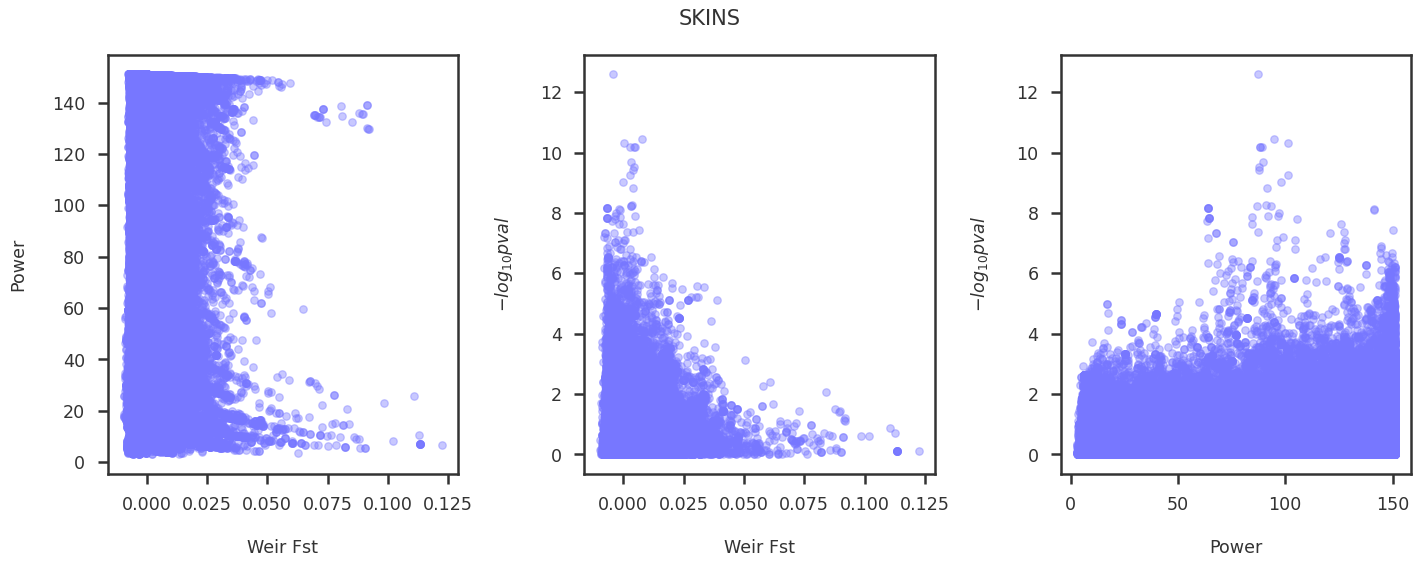

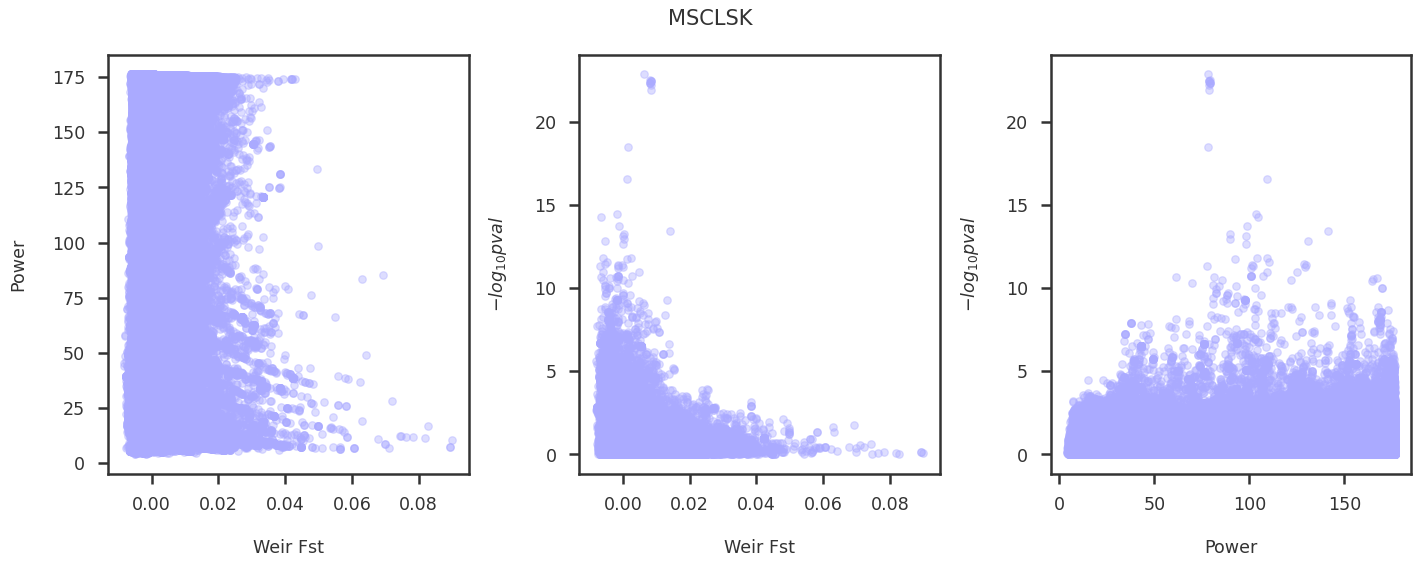

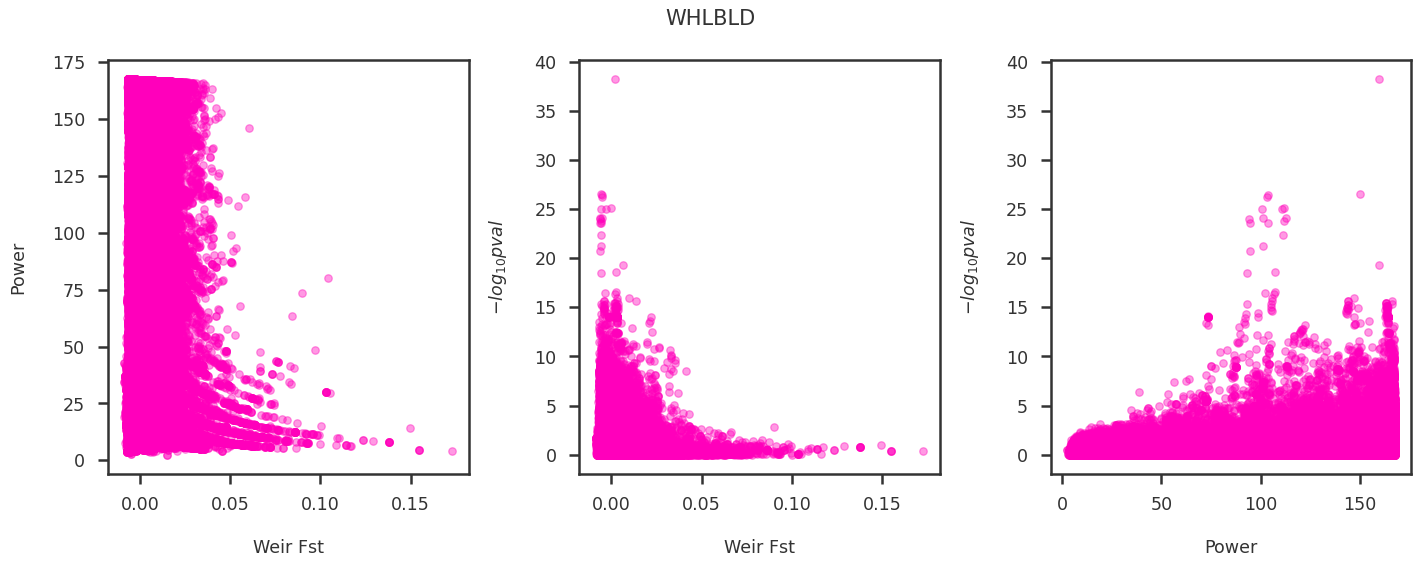

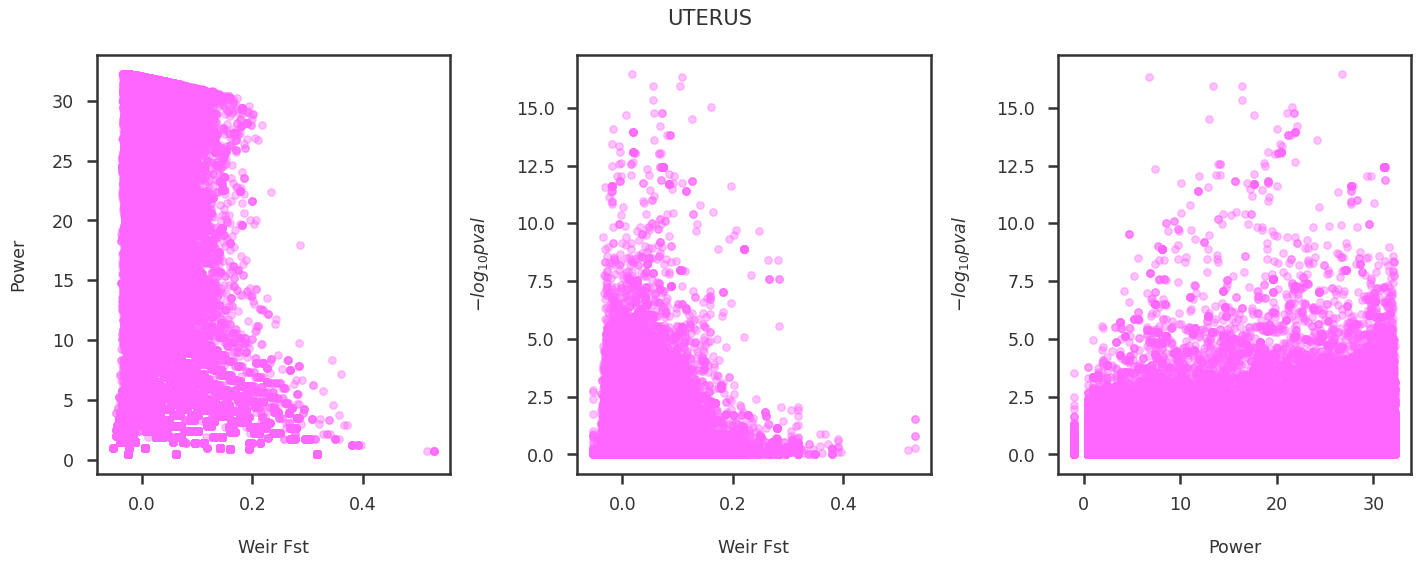

In [95]:
for tissue in select_tissues:
    fig = plt.figure(figsize=(16,6))
    fig.suptitle(f"{tissue_names[tissue]}", y=1.05)
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)

    pval_arr = list()
    weir_arr = list()
    power_arr = list()
    for snp in tejaas_results[tissue]:
        if snp.rsid in gw_tissue_fst[tissue]:
            weir, fst, power = gw_tissue_fst[tissue][snp.rsid]
            pval_arr.append(snp.logp)
            weir_arr.append(weir)
            power_arr.append(power)
#             if snp.logp > 9 and snp.rsid in teqtl_tissue_fst_3pop[tissue]:
#                 print(snp.rsid, teqtl_tissue_fst_3pop[tissue][snp.rsid], gw_tissue_fst[tissue][snp.rsid])

    ax1.scatter(weir_arr, power_arr, color=tissue_colors[tissue], alpha=0.4)
    ax2.scatter(weir_arr, pval_arr, color=tissue_colors[tissue], alpha=0.4)
    ax3.scatter(power_arr, pval_arr, color=tissue_colors[tissue], alpha=0.4)

    ax1.set_xlabel("Weir Fst")
    ax1.set_ylabel("Power")

    ax2.set_xlabel("Weir Fst")
    ax2.set_ylabel("$-log_{10} pval$")
    
    ax3.set_xlabel("Power")
    ax3.set_ylabel("$-log_{10} pval$")

    plt.tight_layout()
    plt.show()

In [97]:
def write_samples(samplenames, outfile):
    with open(outfile, 'w') as outstream:
        outstream.write("ID_1 ID_2 missing father mother pheno\n")
        outstream.write("0 0 0 D D B\n")
        for sid in samplenames:
            outstream.write(f"{sid} {sid} 0 0 0 -9\n")

def write_list(samplenames, outfile):
    with open(outfile, 'w') as outstream:
        for sid in samplenames:
            outstream.write(f"{sid}\n")

outdir="/cbscratch/franco/datasets/gtex_v8/genotypes/sample_files"
if not os.path.exists(outdir):
    os.makedirs(outdir)

for tissue in tshorts:
    outfile = "gtex_v8_{:s}_{:s}.sample"
    outlist = "gtex_v8_{:s}_{:s}.list"
    sampids = tissue_samples[tissue]
    ix_eur, ix_afr, ix_oth = find_ancestry_3pop(sampids, sample_pheno_dict)
    t_eur_samples = [sampids[i] for i in ix_eur]
    t_afr_samples = [sampids[i] for i in ix_afr]
    t_oth_samples = [sampids[i] for i in ix_oth]
    
    write_samples(t_eur_samples, os.path.join(outdir,outfile.format(tissue, "eur")))
    write_samples(t_afr_samples, os.path.join(outdir,outfile.format(tissue, "afr")))
    write_samples(t_oth_samples, os.path.join(outdir,outfile.format(tissue, "oth")))
    
    write_list(t_eur_samples, os.path.join(outdir,outlist.format(tissue, "eur")))
    write_list(t_afr_samples, os.path.join(outdir,outlist.format(tissue, "afr")))
    write_list(t_oth_samples, os.path.join(outdir,outlist.format(tissue, "oth")))